In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# Number of classes
K = len(np.unique(y_train)) 

# Number of train images
Ntr = x_train.shape[0]
# Number of test images
Nte = x_test.shape[0]

# Pixels in an image 
Din = 3072 # CIFAR10

mean_image = np.mean(x_train, axis=0)

# Centering data by subtracting mean
x_train = x_train - mean_image
x_test = x_test - mean_image

# Denoting the relevant class in a binary manner
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

# Reshaping 
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [2]:
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [3]:
# Setting the initial values of parameters W,b
std=1e-5
H = 200
w1 = std*np.random.randn(Din, H)
w2 = std*np.random.randn(H,K)
b1 = np.zeros(H)
b2 = np.zeros(K)
print("w1:", w1.shape)
print("b1:", b1.shape)
print("w2:", w2.shape)
print("b2:", b2.shape)


# Defining parameters
batch_size = 500 
epochs = 300 # Iterations
lr = 0.014# Learning rate
lr_decay= 0.99995
reg = 5e-6 # Regularization 


loss_history = []
acc_list_test =[]
loss_history_test =[]
acc_list=[]


w1: (3072, 200)
b1: (200,)
w2: (200, 10)
b2: (10,)


In [4]:
seed = 0
rng = np.random.default_rng(seed=seed)
for t in range(epochs):
    loss_list=[]
    accuracy_list=[]
    indices = np.arange(Ntr)
    rng.shuffle(indices)

    x = x_train[indices]
    y = y_train[indices]

    indices_t = np.arange(Nte)
    rng.shuffle(indices_t)

    x_ = x_test[indices_t] # numpy array (10,000 x 3072)
    y_ = y_test[indices_t] # (10,000 x 10)
    
    n = int(Ntr/batch_size)
    x_batches = np.array_split(x, n)
    y_batches = np.array_split(y, n) 
    for i in range(n):
        h = 1.0/(1.0 + np.exp(-(x_batches[i].dot(w1) +b1)))
        y_pred = h.dot(w2) + b2

        loss = (1./batch_size)*np.square(y_pred -y_batches[i]).sum() + reg * (np.sum(w2 * w2) + np.sum( w1 * w1 ))
        loss_list.append(loss)

        acc = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batches[i], axis =1))
        acc = acc/batch_size
        accuracy_list.append(acc)

        dy_pred = (1./batch_size)*2.0*(y_pred -y_batches[i]) # partial derivative of L w.r.t y_hat
        dw2 = h.T.dot(dy_pred) + reg*w2
        db2 = dy_pred.sum(axis =0)
        dh = dy_pred.dot(w2.T)
        dw1 = x_batches[i].T.dot(dh*h*(1-h)) + reg*w1
        db1 = (dh*h*(1-h)).sum(axis =0)
        
        # decrementing parameters for gradient descent
        w1 -= lr*dw1
        w2 -= lr*dw2
        b1 -= lr*db1
        b2 -= lr*db2
        lr *= lr_decay
    loss_iteration = sum(loss_list)/n
    loss_history.append(loss_iteration)
    acc_iteration = sum(accuracy_list)/n
    acc_list.append(acc_iteration)

    h2 = 1.0/(1.0 + np.exp(-(x_.dot(w1) +b1)))
    y_pred_t = h2.dot(w2) + b2

    loss_te = (1./Nte)*np.square(y_pred_t -y_).sum() + reg * (np.sum(w2 * w2) + np.sum( w1 * w1 ))
    loss_history_test.append(loss_te)
    acc_te = np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_, axis =1))
    acc_te = acc_te/Nte
    acc_list_test.append(acc_te)
    if (t+1)%50 ==0 or t==0:
        print('Epoch %d / %d: Training Loss : %f | Testing Loss : %f | Training Accuracy : %f | Validation Accuracy : %f | LR: %f' % (t+1, epochs, loss,loss_te ,acc, acc_te,lr))

Epoch 1 / 300: Training Loss : 0.801227 | Testing Loss : 0.800075 | Training Accuracy : 0.314000 | Validation Accuracy : 0.364400 | LR: 0.013930
Epoch 50 / 300: Training Loss : 0.586941 | Testing Loss : 0.783300 | Training Accuracy : 0.688000 | Validation Accuracy : 0.438300 | LR: 0.010903
Epoch 100 / 300: Training Loss : 0.517563 | Testing Loss : 0.835152 | Training Accuracy : 0.790000 | Validation Accuracy : 0.426500 | LR: 0.008491
Epoch 150 / 300: Training Loss : 0.430353 | Testing Loss : 0.879545 | Training Accuracy : 0.864000 | Validation Accuracy : 0.420900 | LR: 0.006613
Epoch 200 / 300: Training Loss : 0.392568 | Testing Loss : 0.911428 | Training Accuracy : 0.904000 | Validation Accuracy : 0.412100 | LR: 0.005150
Epoch 250 / 300: Training Loss : 0.379403 | Testing Loss : 0.936133 | Training Accuracy : 0.904000 | Validation Accuracy : 0.407000 | LR: 0.004011
Epoch 300 / 300: Training Loss : 0.329604 | Testing Loss : 0.953291 | Training Accuracy : 0.948000 | Validation Accuracy 

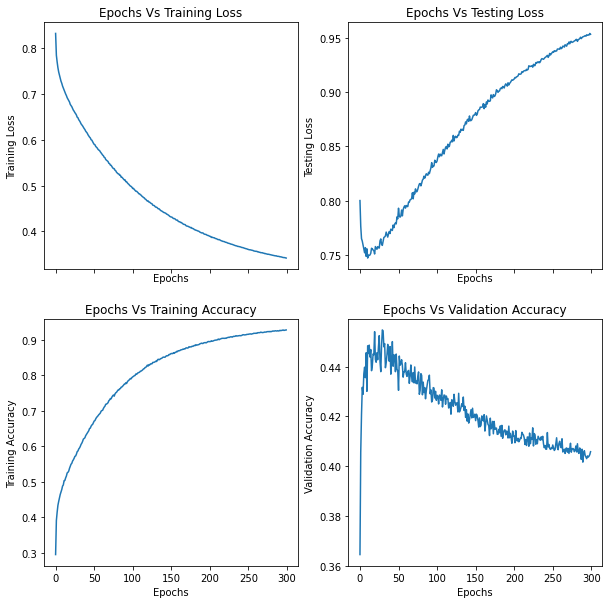

In [5]:

fig, ax = plt.subplots(2,2, figsize = (10,10), sharex=True)

ax[0,0].plot(loss_history)
ax[0,0].set_title('Epochs Vs Training Loss')
ax[0,0].set(xlabel='Epochs', ylabel='Training Loss')

ax[0,1].plot(loss_history_test)
ax[0,1].set_title('Epochs Vs Testing Loss')
ax[0,1].set(xlabel='Epochs', ylabel='Testing Loss')


ax[1,0].plot(acc_list)
ax[1,0].set_title('Epochs Vs Training Accuracy')
ax[1,0].set(xlabel='Epochs', ylabel='Training Accuracy')

ax[1,1].plot(acc_list_test)
ax[1,1].set_title('Epochs Vs Validation Accuracy')
ax[1,1].set(xlabel='Epochs', ylabel='Validation Accuracy')

plt.show()
